# Bepaal het effect van een stijging van het peil van de Amstel
Dit notebook berekent het effect van een stijging van het peil van Amstel. Voor een gebied van 4 bij 3 km lezen we data in, zetten dit om naar modelinvoer en rekenen een tijdsafhankelijk grondwatermodel voor enkele jaren door.

Het notebook is slechts ter illustratie van de mogelijkheden van nlmod. Hoewel er gerekend wordt met echte data voor de ondergrond en het oppervlaktewater, wordt ontbrekende/onbekende data (bijvoorbeeld de weerstand van de Holocene deklaag, het peil van de Amstel, of de weerstand van het oppervlaktewater) opgevuld met eenvoudige aannames. Het model is op geen enkele manier gecontrolleerd of gekalibreerd, bijvoorbeeld op basis van metingen. Het model geeft de werkelijkheid waarschijnlijk dan ook niet goed weer.

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import flopy
import nlmod
logger = nlmod.util.get_color_logger("INFO");

In [2]:
model_name = "Amstel"
model_ws = "amstel"
figdir, cachedir = nlmod.util.get_model_dirs(model_ws)
extent = [118_000, 122_000, 473_000, 476_000]
line = [(118_000, 474_500), (122_000, 474_500)]
time = pd.date_range("2020", "2023", freq="MS")  # monthly timestep

## Lagenmodel
We lezen een lagenmodel in op basis van REGIS.

In [3]:
layer_model = nlmod.read.regis.get_combined_layer_models(
    extent,
    use_regis=True,
    use_geotop=False,
    cachedir=cachedir,
    cachename="layer_model.nc",
)
layer_model

INFO:nlmod.cache:caching data -> layer_model.nc


<xarray.Dataset>
Dimensions:  (layer: 29, y: 30, x: 40)
Coordinates:
  * x        (x) float64 1.18e+05 1.182e+05 1.182e+05 ... 1.218e+05 1.22e+05
  * y        (y) float64 4.76e+05 4.758e+05 4.758e+05 ... 4.732e+05 4.73e+05
  * layer    (layer) <U64 'HLc' 'BXz3' 'BXz4' 'KRz3' ... 'OOz2' 'OOc' 'BRk1'
Data variables:
    top      (layer, y, x) float32 ...
    botm     (layer, y, x) float32 -11.26 -11.25 -11.23 ... -593.6 -594.4 -595.7
    kh       (layer, y, x) float32 ...
    kv       (layer, y, x) float32 ...
Attributes: (12/40)
    references:                    https://www.dinoloket.nl/regis-ii-het-hydr...
    Conventions:                   CF-1.7
    creator_url:                   https://www.dinoloket.nl
    keywords_vocabulary:           NASA/GCMD Earth Science Keywords. Version 6.0
    acknowledgment:                https://www.dinoloket.nl
    project:                       REGIS v02r2
    ...                            ...
    geospatial_lon_resolution:     0.0014573401
    geospatial_vertical_min:       -1235.92
    geospatial_vertical_max:       322.75
    geospatial_vertical_units:     m-NAP
    geospatial_vertical_positive:  up
    extent:                        [118000, 122000, 473000, 476000]

Wanneer we het lagenomdel omzetten naar een model Dataset zien we aan de log-berichten dat er geen informatie is over de doorlatendheid van de Holocene deklaag, en dat nlmod deze doorlatendheden opvult met de standaard-waarden van kh=1.0 m/d, en kv=0.1 m/d.

In [4]:
ds = nlmod.to_model_ds(layer_model, model_name, model_ws, delr=50.0)
ds = nlmod.time.set_ds_time(ds, time=time)

INFO:nlmod.dims.base:resample layer model data to structured modelgrid
INFO:nlmod.dims.layers:kv and kh both undefined in layer HLc
INFO:nlmod.dims.layers:Filling 23084 values in active cells of kh by multipying kv by an anisotropy of 10
INFO:nlmod.dims.layers:Filling 77260 values in active cells of kv by dividing kh by an anisotropy of 10
INFO:nlmod.dims.layers:Filling 4800 values in active cells of kh with a value of 1.0 m/day
INFO:nlmod.dims.layers:Filling 4800 values in active cells of kv with a value of 0.1 m/day


We kunnen het lagenmodel weergeven in een (eerder gedefinieerde) doorsnede van west naar oost. De dikte van de Holocene deklaag bedraagt ongeveer 10 meter in deze doorsnede.

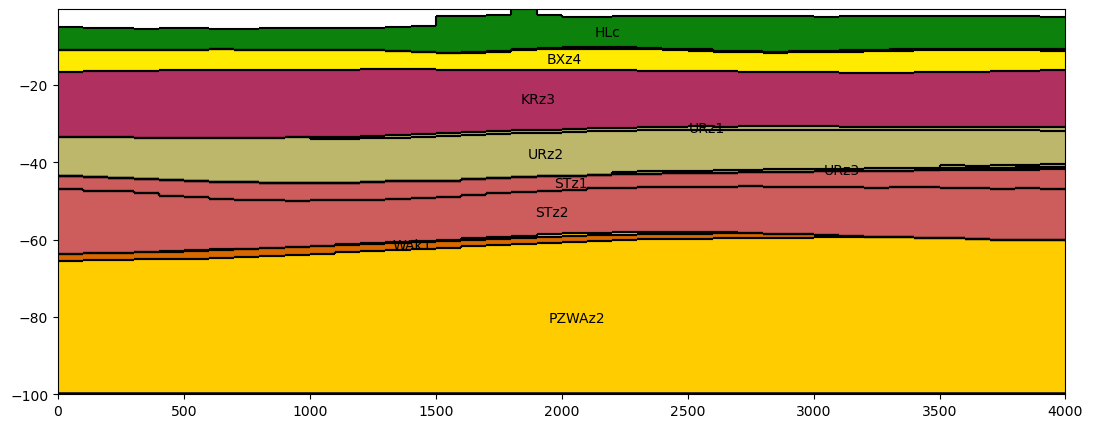

In [5]:
f, ax = plt.subplots(figsize=(13, 5))
dcs = nlmod.plot.DatasetCrossSection(ds, line, ax=ax, zmin=-100)
colors = nlmod.read.regis.get_legend()['color'].to_dict()
for layer in ds.layer.data:
    if layer not in colors:
        colors[layer] = colors['HLc']
dcs.plot_layers(colors=colors, min_label_area=1000.0)
dcs.plot_grid(vertical=False);

Oefening 1: geef de hozizontale doorlatendheid (kh) weer in een doorsnede langs dezelfde lijn. Gebruik de methode `dcs.plot_array()` om de variabele 'kh' in ds te tekenen (voeg dus de variabele `ds["kh"]` toe als eerste argument aan `dcs.plot_array()`).

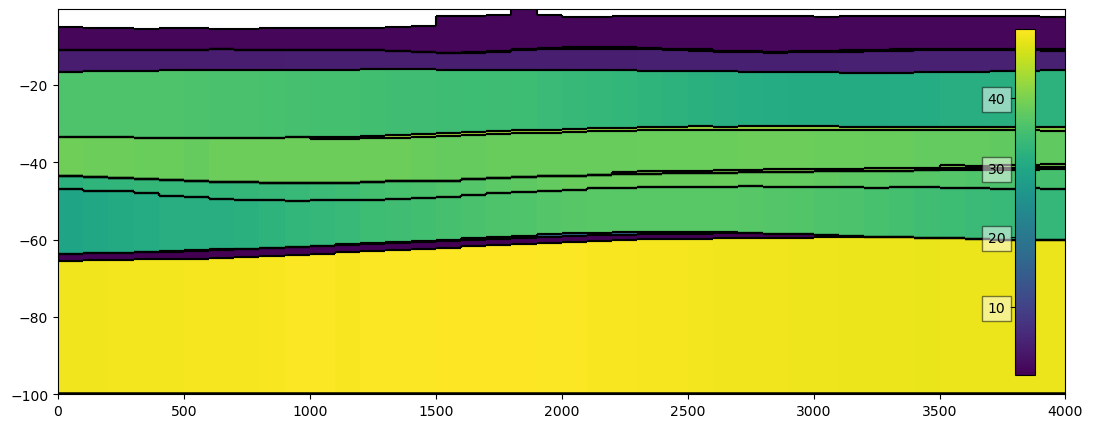

In [6]:
f, ax = plt.subplots(figsize=(13, 5))
dcs = nlmod.plot.DatasetCrossSection(ds, line, ax=ax, zmin=-100)
pc = dcs.plot_array(ds['kh'])
nlmod.plot.colorbar_inside(pc)
dcs.plot_grid(vertical=False);

Oefening 2: Geef de dikte van de holocene deklaag weer. Bereken de dikte van de lagen met behlp van de methode `nlmod.layers.calculate_thickness(ds)` en selecteer de eerste laag (`"HLc"`) uit de resulterde DataArray met behulp van `da.loc[]`.

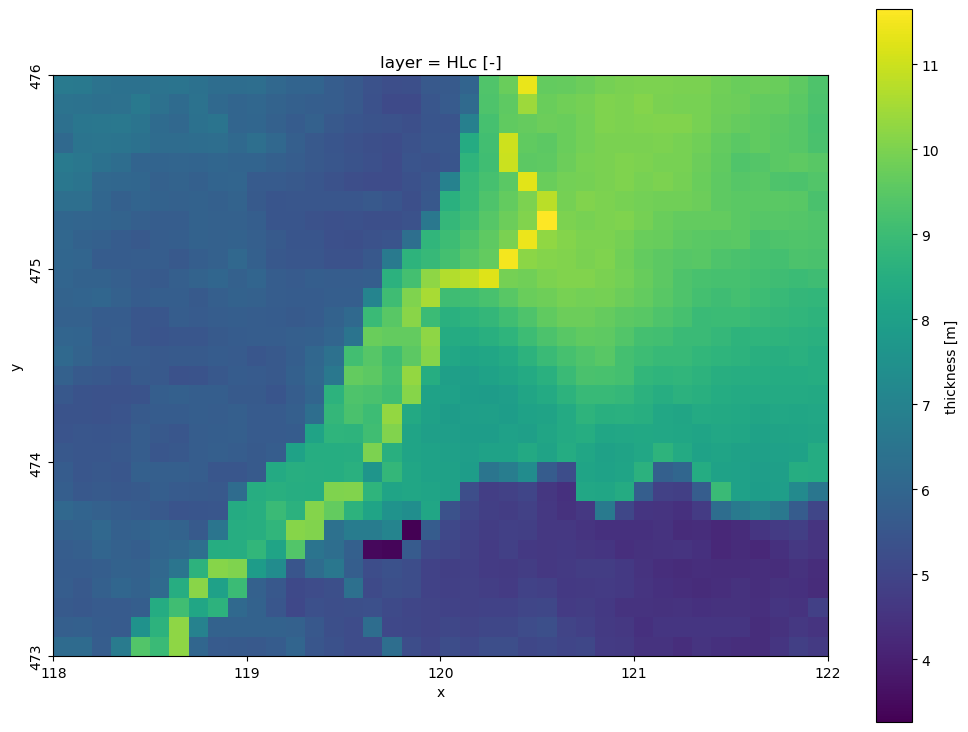

In [7]:
thickness = nlmod.layers.calculate_thickness(ds)
f, ax = nlmod.plot.get_map(extent)
thickness.loc['HLc'].plot(ax=ax);

## Download oppervlaktewaterdata
We downloaden de locatie van het oppervlaktewater uit de BasisRegistratie Grootschalige Topografie (BGT), en peilgebieden van de in het modelgebied liggende waterschappen (in dit geval alleen van Waterschap Amstel Gooi en Vecht). Om deze webservces niet te overbelasten, slaan we het resultaat op in een bestand genaamd `bgt.geojson`, zodat we dit slechts één keer doen.

In [8]:
fname = os.path.join(cachedir, 'bgt.geojson')
if not os.path.isfile(fname):
    bgt = nlmod.read.bgt.get_bgt(extent)
    la = nlmod.gwf.surface_water.download_level_areas(bgt, extent=extent, raise_exceptions=False)
    bgt = nlmod.gwf.surface_water.add_stages_from_waterboards(bgt, la=la)
    bgt.to_file(fname, driver="GeoJSON")
else:
    logger.info('using cached data -> bgt.geojson')
bgt = gpd.read_file(fname)

INFO:nlmod.gwf.surface_water:Downloading level_areas for Amstel, Gooi en Vecht


Adding ['summer_stage', 'winter_stage'] from Amstel, Gooi en Vecht: 100%|█████████| 1092/1092 [00:02<00:00, 437.04it/s]


Het resulterende object is een zogenaamd GeoDataFrame, waarbij elke rij een watervalk voorstelt. Het zomerpeil ('summer_stage') en winterpeil ('winter_stage') zijn afgeleid uit de peilgebieden-data en als extra kolommen door nlmod aan de bgt-data toegevoegd.

In [9]:
bgt

id creationDate  LV-publicatiedatum  \
0     bda4924cb-6df4-de50-408e-bd293b2b4f4f   2015-07-07 2015-12-22 23:47:09   
1     b313d3298-0f75-2c88-4e0f-5a176c7dee88   2015-07-01 2015-12-22 23:47:09   
2     b8b01fc62-73ac-50ba-cc82-cf27d2786df4   2015-07-01 2015-12-22 23:47:09   
3     bb4084899-b48c-aa73-0863-4a36c0cbde9d   2015-07-01 2015-12-22 23:47:09   
4     b411cc135-27d3-c130-2796-288c3e6df049   2015-07-01 2015-12-22 23:47:09   
...                                     ...          ...                 ...   
1097  b2cc8ec57-d3b7-21a6-eb75-decbc55c2a80   2015-06-18 2021-08-06 06:37:31   
1098  b8d07ab7d-6e0b-c7ff-8045-778376d61671   2015-06-18 2021-09-21 15:24:04   
1099  bc4e999ca-010d-0f76-346b-368d58b8e579   2015-06-18 2021-09-21 15:24:04   
1100  ba5296784-176e-ae05-fd2a-d481f8460647   2015-06-18 2021-09-21 15:24:04   
1101  bd528b2f2-45bd-8f08-3fb4-582cea69c091   2015-06-18 2021-09-21 15:24:04   

     relatieveHoogteligging inOnderzoek tijdstipRegistratie  \
0                         0       false 2015-07-07 10:21:43   
1                         0       false 2015-07-01 08:23:46   
2                         0       false 2015-07-14 10:01:04   
3                         0       false 2015-07-01 08:23:46   
4                         0       false 2015-08-19 15:09:23   
...                     ...         ...                 ...   
1097                      0       false 2021-08-06 06:06:31   
1098                      0       false 2021-09-21 14:56:09   
1099                      0       false 2021-09-21 14:56:09   
1100                      0       false 2021-09-21 14:56:09   
1101                      0       false 2021-09-21 14:56:09   

                               identificatie bronhouder bgt-status  \
0     G0362.3642abefe30a4888855d428b348e1b72      W0155   bestaand   
1     G0362.43d7fd55272d4f298ec43fe8446dc65c      W0155   bestaand   
2     G0362.488300540a6e4866b60c754ecdbeef98      W0155   bestaand   
3     G0362.ca76469073ae41719bb7ba5414643c0e      W0155   bestaand   
4     G0362.f1b6fbcf352a48d6b03edab4f1b11697      W0155   bestaand   
...                                      ...        ...        ...   
1097  G0362.1582d5fbc2f441d1a1dd16cdbb3d0184      W0155   bestaand   
1098  G0362.3235bed417184f678a3f80f028c2e3b4      W0155   bestaand   
1099  G0362.924ebb5f3db244f9b902550808230aa8      W0155   bestaand   
1100  G0362.d343749c6a4f4e19ab76d8057bf8bbae      W0155   bestaand   
1101  G0362.fc0db764a2f743cf9e1b36eefa0ec9e8      W0155   bestaand   

     plus-status      class       plus-type  eindRegistratie  terminationDate  \
0     geenWaarde  waterloop  waardeOnbekend              NaN              NaN   
1     geenWaarde  waterloop  waardeOnbekend              NaN              NaN   
2     geenWaarde  waterloop  waardeOnbekend              NaN              NaN   
3     geenWaarde  waterloop  waardeOnbekend              NaN              NaN   
4     geenWaarde  waterloop  waardeOnbekend              NaN              NaN   
...          ...        ...             ...              ...              ...   
1097  geenWaarde  waterloop  waardeOnbekend              NaN              NaN   
1098  geenWaarde  waterloop  waardeOnbekend              NaN              NaN   
1099  geenWaarde  waterloop  waardeOnbekend              NaN              NaN   
1100  geenWaarde  waterloop  waardeOnbekend              NaN              NaN   
1101  geenWaarde  waterloop  waardeOnbekend              NaN              NaN   

      summer_stage  winter_stage  \
0            -5.90         -5.90   
1            -5.90         -5.90   
2            -5.90         -5.90   
3            -5.90         -5.90   
4            -5.90         -5.90   
...            ...           ...   
1097         -2.52         -2.52   
1098         -2.52         -2.52   
1099         -2.52         -2.52   
1100         -2.52         -2.52   
1101         -2.52         -2.52   

                                               geometry  
0     POLYGON ((11

Oefening 3: geef de gedownloade polygonen van het oppervlaktewater weer. Maak een kaart aan met de functie `f, ax = nlmod.plot.get_map(extent)` en plot het oppervlaktewater met `bgt.plot(ax=ax)`.

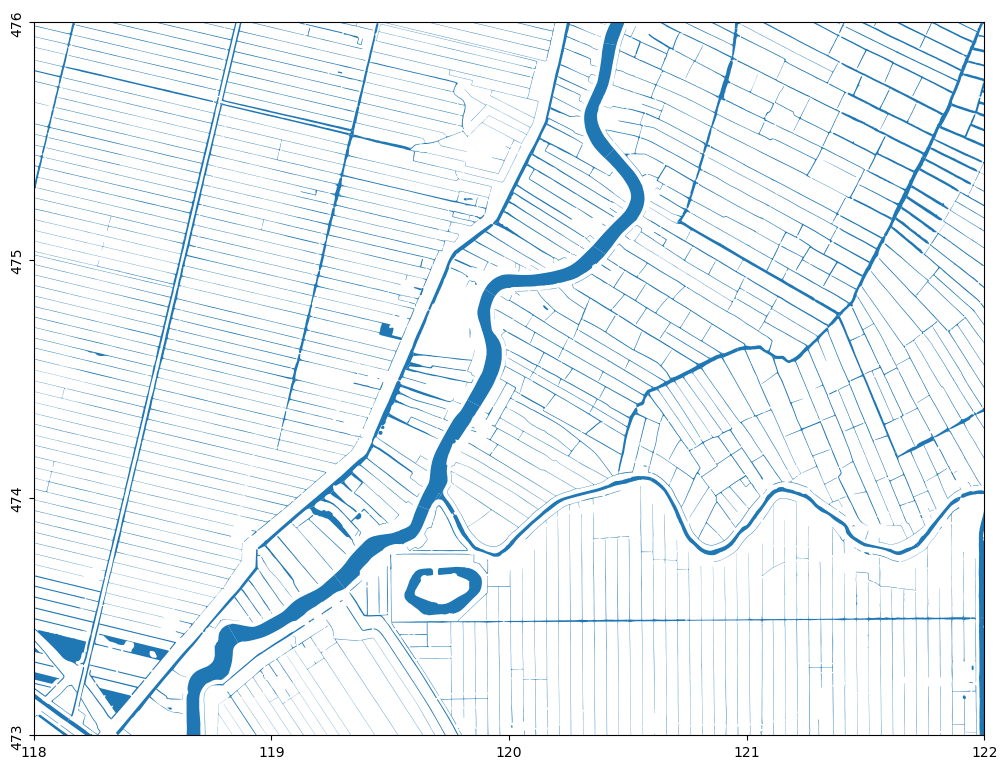

In [10]:
f, ax = nlmod.plot.get_map(extent)
bgt.plot(ax=ax);

Oefening 4: Geef de bronhouder weer van de data. Voeg `"bronhouder"` toe als eerste argument aan `bgt.plot()` en geef een legenda weer door een extra argument `legend=True` mee te geven.

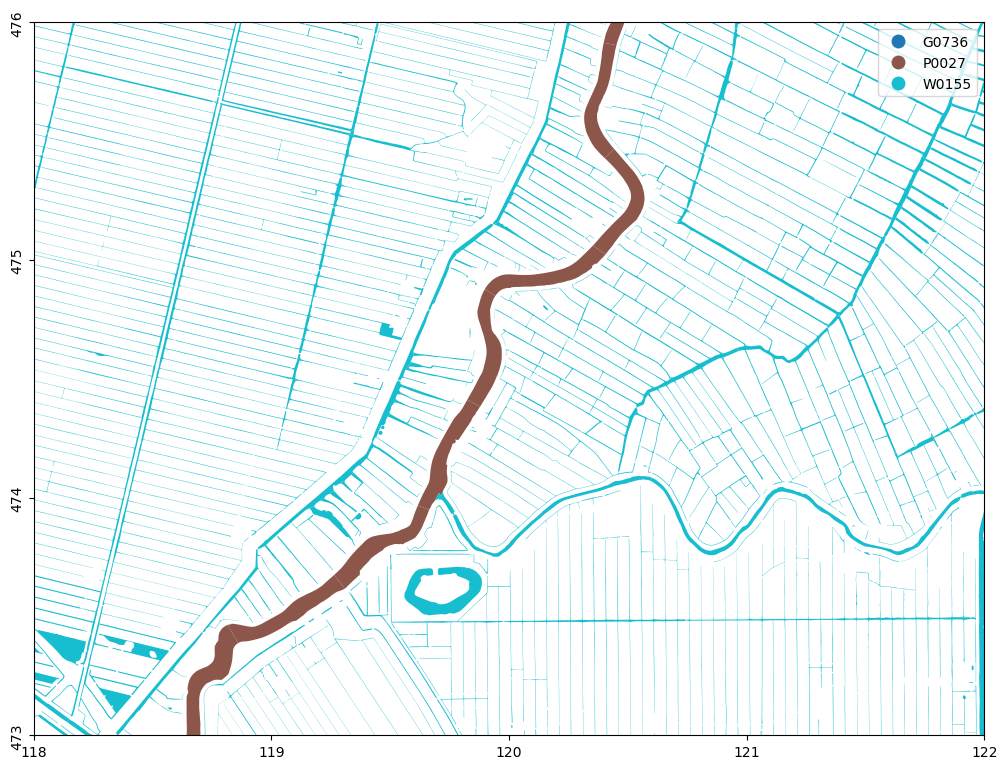

In [11]:
f, ax = nlmod.plot.get_map(extent);
bgt.plot('bronhouder', ax=ax, legend=True);

Uit deze figuur is te zien dat 'W0155' de brondhouder is van de meeste waterlopen in dit gebied: Waterschap Amstel, Gooi en Vecht. De Amstel zelf heeft als bronhouder de provincie Noord-Holland.

Een belangrijke invoer voor het grondwatermodel is het zomerpeil en het winterpeil. Deze geven we ruimtelijk weer.

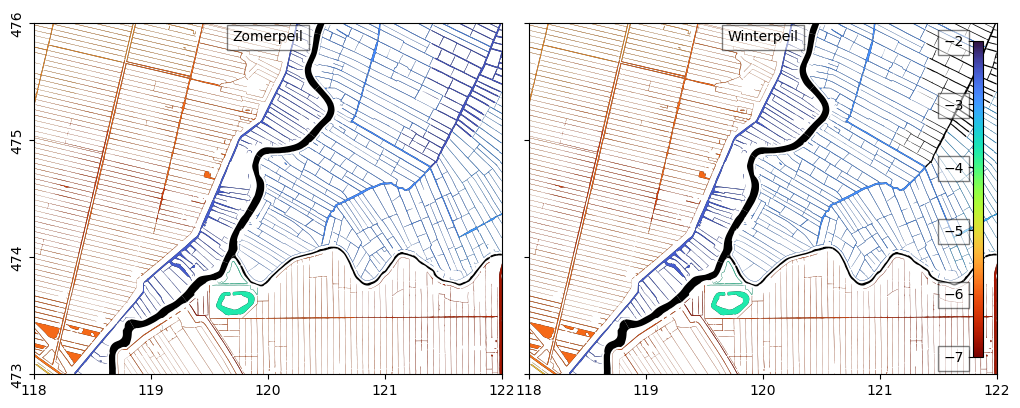

In [12]:
f, axes = nlmod.plot.get_map(extent, ncols=2)
norm = matplotlib.colors.Normalize(-7.0, -2.0)
cmap = 'turbo_r'

bgt.plot(color='k', ax=axes[0])
bgt.plot('summer_stage', ax=axes[0], norm=norm, cmap=cmap)
nlmod.plot.title_inside('Zomerpeil', ax=axes[0])

bgt.plot(color='k', ax=axes[1])
bgt.plot('winter_stage', ax=axes[1], norm=norm, cmap=cmap)
nlmod.plot.colorbar_inside(cmap=cmap, norm=norm)
nlmod.plot.title_inside('Winterpeil', ax=axes[1]);

Locaties die zwart blijven in beide figuren vallen niet in een peilgebied, en krijgen dan ook geen zomer- of winterpeil toegekend. Dit zijn de Amstel zelf en de aangrenzende waterloop: de Oude Waver. Voor de Amstel geven we later in dit notebook een handmatig peil op. Voor de Oude Waver laten we de peilen leeg, waardoor deze genegeerd wordt bij het aanmaken van de oppervlaktewater-invoer van het model (zie ook de log-berichten later in dit notebook).

In het noordoosten van het gebied zijn enkele locaties zonder winterpeil, waar wel een zomerpeil gedefinieerd is (wellicht veroorzaakt door een fout bij de interpretatie van de waterschapsdata door nlmod). Daarom vullen we ontbrekende waarden van het winterpeil in door het zomerpeil. De resterende ontbrekende peilen bestaan dan uit de Oude Waver. 

In [13]:
mask = bgt["winter_stage"].isna()
bgt.loc[mask, "winter_stage"] = bgt.loc[mask, "summer_stage"]

## Download neerslag en verdamping
We downloaden neerslag en verdamping van het KNMI en berekenen hieruit de grondwateraanvulling (het neerslagoverschot) in elke tijdstap, en voegen dit toe aan de modeldataset met de vraiabele `"recharge"'.

In [14]:
knmi_ds = nlmod.read.knmi.get_recharge(ds, cachedir=cachedir, cachename="recharge.nc")
ds.update(knmi_ds)

INFO:hydropandas.io.knmi:last RD measurement available at the Bilt is from 2023-08-10
INFO:hydropandas.io.knmi:assuming no RD measurements are available at other stations after this date
INFO:hydropandas.io.knmi:changing end_date to 2023-01-01
INFO:hydropandas.io.knmi:download knmi RD data from station 458-AALSMEER between 2010-01-01 00:00:00 and 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:station 458 has 0 missing measurements
INFO:hydropandas.io.knmi:last RD measurement available at the Bilt is from 2023-08-10
INFO:hydropandas.io.knmi:assuming no RD measurements are available at other stations after this date
INFO:hydropandas.io.knmi:changing end_date to 2023-01-01
INFO:hydropandas.io.knmi:download knmi RD data from station 572-ABCOUDE between 2010-01-01 00:00:00 and 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:station 572 has 0 missing measurements
INFO:hydropandas.io.knmi:download knmi EV24 data from station 240-SCHIPHOL between 2010-01-01 00:00:00 and 2023-01-01 00:00:00
INFO:hyd

<xarray.Dataset>
Dimensions:   (y: 60, x: 80, layer: 29, time: 37)
Coordinates:
  * layer     (layer) <U64 'HLc' 'BXz3' 'BXz4' 'KRz3' ... 'OOz2' 'OOc' 'BRk1'
  * x         (x) float64 1.18e+05 1.181e+05 1.181e+05 ... 1.219e+05 1.22e+05
  * y         (y) float64 4.76e+05 4.759e+05 4.759e+05 ... 4.731e+05 4.73e+05
  * time      (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2023-01-01
Data variables:
    top       (y, x) float32 -4.59 -4.59 -4.61 -4.61 ... -5.53 -5.53 -5.88 -5.88
    botm      (layer, y, x) float32 -11.26 -11.26 -11.25 ... -595.7 -595.7
    kh        (layer, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 0.02 0.02 0.02 0.02
    kv        (layer, y, x) float32 0.1 0.1 0.1 0.1 ... 0.002 0.002 0.002 0.002
    area      (y, x) float64 2.5e+03 2.5e+03 2.5e+03 ... 2.5e+03 2.5e+03 2.5e+03
    idomain   (layer, y, x) int32 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    recharge  (time, y, x) float64 0.0008456 0.0008456 ... 0.003003 0.003003
Attributes:
    extent:                    [118000, 122000, 473000, 476000]
    gridtype:                  structured
    delr:                      50.0
    delc:                      50.0
    model_name:                Amstel
    mfversion:                 mf6
    model_dataset_created_on:  20230830_10:25:00
    exe_name:                  C:\Users\ruben\Documents\GitHub\nlmod\nlmod\bi...
    model_ws:                  amstel
    figdir:                    amstel\figure
    cachedir:                  amstel\cache
    transport:                 0

## Maak een Modflow 6 simulation
We genereren een Modflow 6 simulation (sim) en groundwater flow (gwf) model voor flopy aan.

In [15]:
# create simulation
sim = nlmod.sim.sim(ds)

# create time discretisation
tdis = nlmod.sim.tdis(ds, sim)

# create ims
ims = nlmod.sim.ims(sim, complexity='moderate')

# create groundwater flow model
gwf = nlmod.gwf.gwf(ds, sim)

# Create discretization
dis = nlmod.gwf.dis(ds, gwf)

# create node property flow
npf = nlmod.gwf.npf(ds, gwf, save_flows=True)

# Create the initial conditions package
ic = nlmod.gwf.ic(ds, gwf, starting_head=0.0)

# Create the output control package
oc = nlmod.gwf.oc(ds, gwf)

# create storage package
sto = nlmod.gwf.sto(ds, gwf)

# create recharge package
rch = nlmod.gwf.rch(ds, gwf)

INFO:nlmod.sim.sim:creating modflow SIM
INFO:nlmod.sim.sim:creating modflow TDIS
INFO:nlmod.sim.sim:creating modflow IMS
INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow DIS
INFO:nlmod.gwf.gwf:creating modflow NPF
INFO:nlmod.gwf.gwf:creating modflow IC
INFO:nlmod.gwf.gwf:adding 'starting_head' data array to ds
INFO:nlmod.gwf.gwf:creating modflow OC
INFO:nlmod.gwf.gwf:creating modflow STO
INFO:nlmod.gwf.gwf:creating modflow RCH


Building ts packages rch: 100%|██████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 90.74it/s]


## Verwerken oppervlaktewater
We vergridden de oppervlaktewater-vlakken, bereknen de conductane, en splitsen de Amstel van de andere vlakken.

In [16]:
bgt_grid = nlmod.grid.gdf_to_grid(bgt, ds).set_index("cellid")

bed_resistance = 1.0
bgt_grid["cond"] = bgt_grid.area / bed_resistance

# handle the Amstel as a river
mask = bgt_grid["bronhouder"] == "P0027"
amstel = bgt_grid[mask]
bgt_grid = bgt_grid[~mask]

# we remove other surface water features in the same cell as the river Amstel
bgt_grid = bgt_grid[~bgt_grid.index.isin(amstel.index)]

Intersecting with grid: 100%|█████████████████████████████████████████████████████| 1102/1102 [00:08<00:00, 127.04it/s]


## Voeg de Amstel toe via de RIV-package
We voegen de Amstel toe aan het model via de River-package, wat betekent dat deze ook kan infiltreren.

In [17]:
amstel["stage"] = -0.4
amstel["rbot"] = -3.0
spd = nlmod.gwf.surface_water.build_spd(amstel, "RIV", ds)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data={0: spd})

Building stress period data RIV: 100%|█████████████████████████████████████████████| 231/231 [00:00<00:00, 3881.73it/s]


## Voeg het overige oppervlaketwater toe via de DRN-package
We voegen al het overige oppervlaktewater toe als drains, wat betekent dat deze in het model niet kunnen infiltreren.

In [18]:
drn = nlmod.gwf.surface_water.gdf_to_seasonal_pkg(bgt_grid, gwf, ds, save_flows=True);

INFO:nlmod.gwf.surface_water:Filling 7257 NaN's in rbot using a water depth of 0.5 meter.


Building stress period data DRN: 100%|███████████████████████████████████████████| 7155/7155 [00:01<00:00, 4407.27it/s]


Building stress period data DRN: 100%|███████████████████████████████████████████| 7155/7155 [00:01<00:00, 4132.85it/s]


## Voer het model uit en lees uitvoer in

In [19]:
nlmod.sim.write_and_run(sim, ds)

INFO:nlmod.sim.sim:write model dataset to cache
INFO:nlmod.sim.sim:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model Amstel...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package sto...
    writing package rch...
    writing package ts_0...
    writing package ts_1...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 231 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 14310 based on size of stress_period_data
    writing package obs_0...
    writing package ts_2...
INFO:nlmod.sim.sim:run model
FloPy is using the following executable to run the model: ..\..\..\nlmod\nlmod\bin\mf6.exe
                                   MODFLOW 6


We lezen de stijghoogtes en het drainage-debiet in, naar variabelen met namen die eindigen op "0" (ter onderscheid van een volgende berekening).

In [20]:
head0 = nlmod.gwf.output.get_heads_da(ds)
# Get the groundwater level, which is the head in the upper active layer (not all layers are present everywhere)
gws0 = nlmod.gwf.output.get_gwl_from_wet_cells(head0)
q_drn0 = nlmod.gwf.output.get_budget_da('DRN', ds=ds)

## Teken de gemiddelde grondwaterstand
We geven de gemiddelde grondwaterstand in het model weer. Ook geven we een punt weer waar we straks een tijd-grafiek gaan weergeven

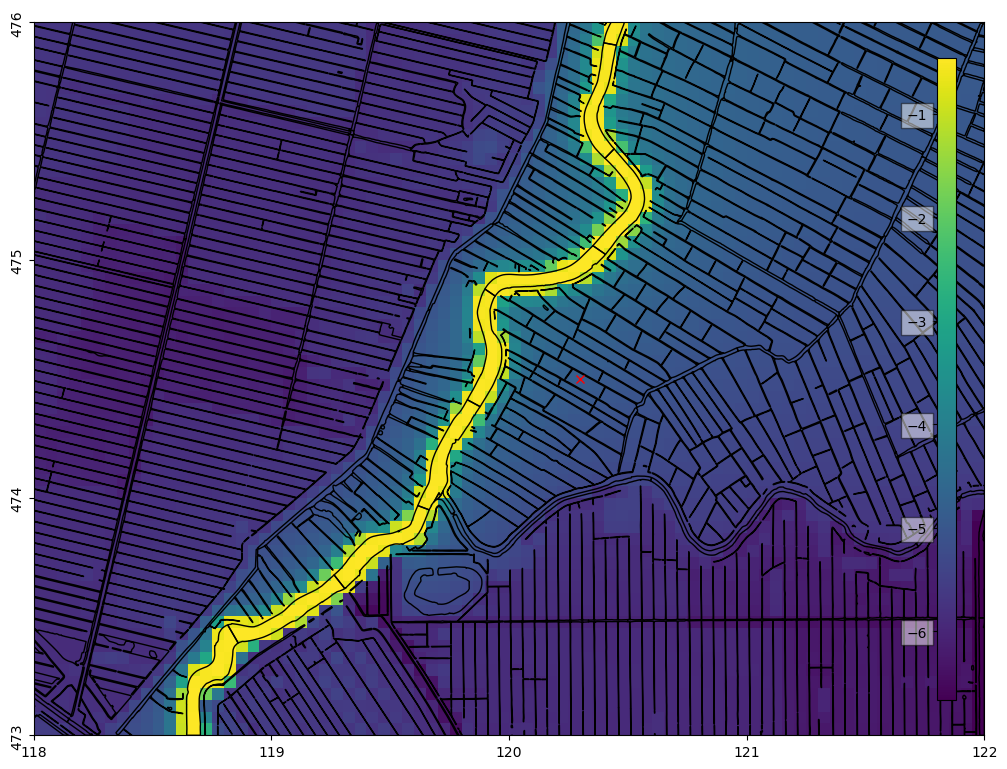

In [21]:
f, ax = nlmod.plot.get_map(extent)
pc = nlmod.plot.data_array(gws0.mean("time"), ds=ds)
cbar = nlmod.plot.colorbar_inside(pc)
bgt.plot(ax=ax, edgecolor="k", facecolor="none")
xp = 120300
yp = 474500
ax.plot(xp, yp, marker='x', color='r');

Geef de stijghoogte in de tijd weer in de verschillende lagen bij het hiervoor gedefinieerde punt, aangegeven met een rood kruisje in voorgaande figuur.

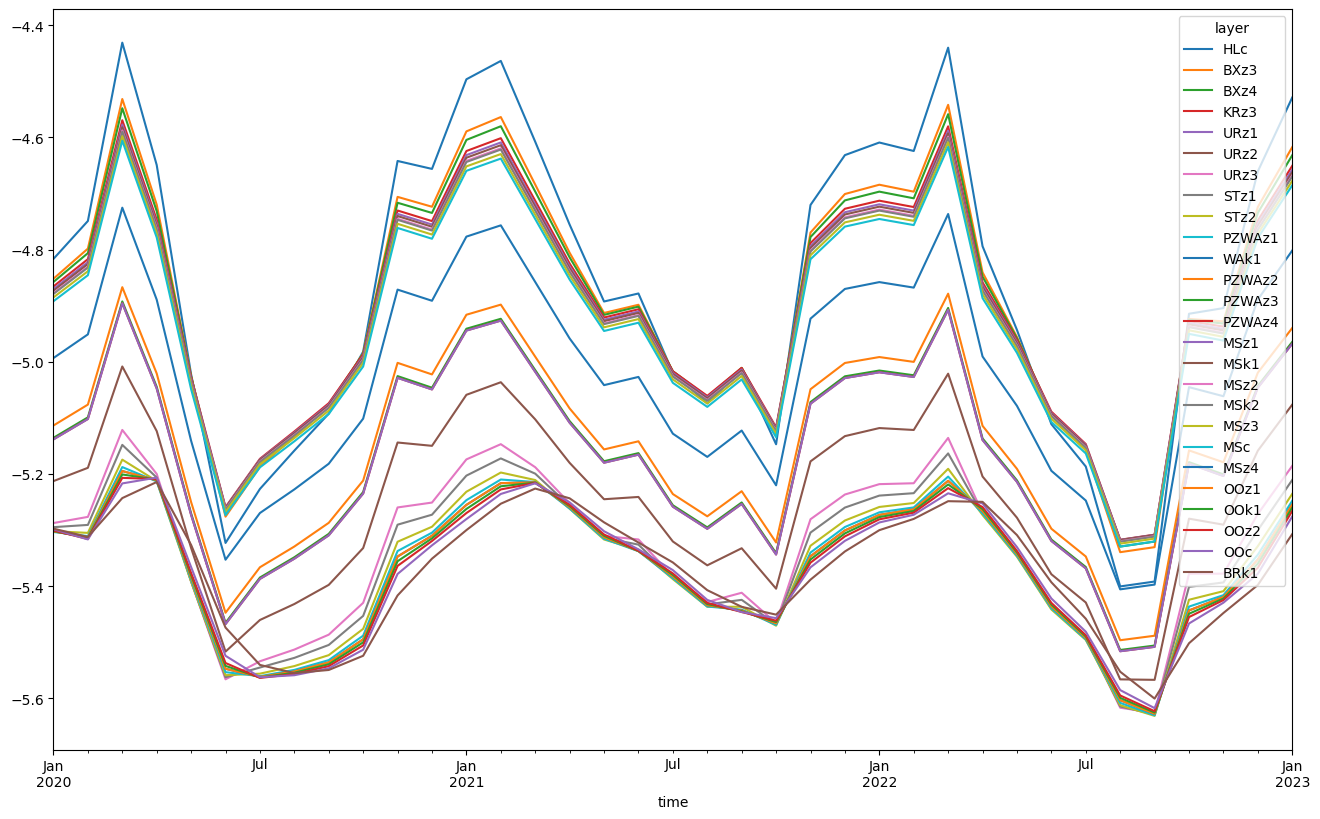

In [22]:
head_point = nlmod.gwf.get_head_at_point(head0, x=xp, y=yp, ds=ds).to_pandas()
ax = head_point.plot(figsize=(13,8))
ax.figure.tight_layout(pad=0.0)

Oefening 5: Geef het gemiddelde drainage-debiet van elke modelcel weer. Bereken hiertoe het drainagedebiet in mm/d, via de methode `da = -q_drn0.sum('layer') / ds['area'] * 1000`. Kijk hoe de grondwaterstand eerder werd getekend, en vervang `gws0` door `da`. En mooie kleurenschaal (`cmap`) voor deze data is `"Blues"`. Vieg daarom het extra argument `cmap="Blues"` toe aan `nlmod.plot.data_array()`.

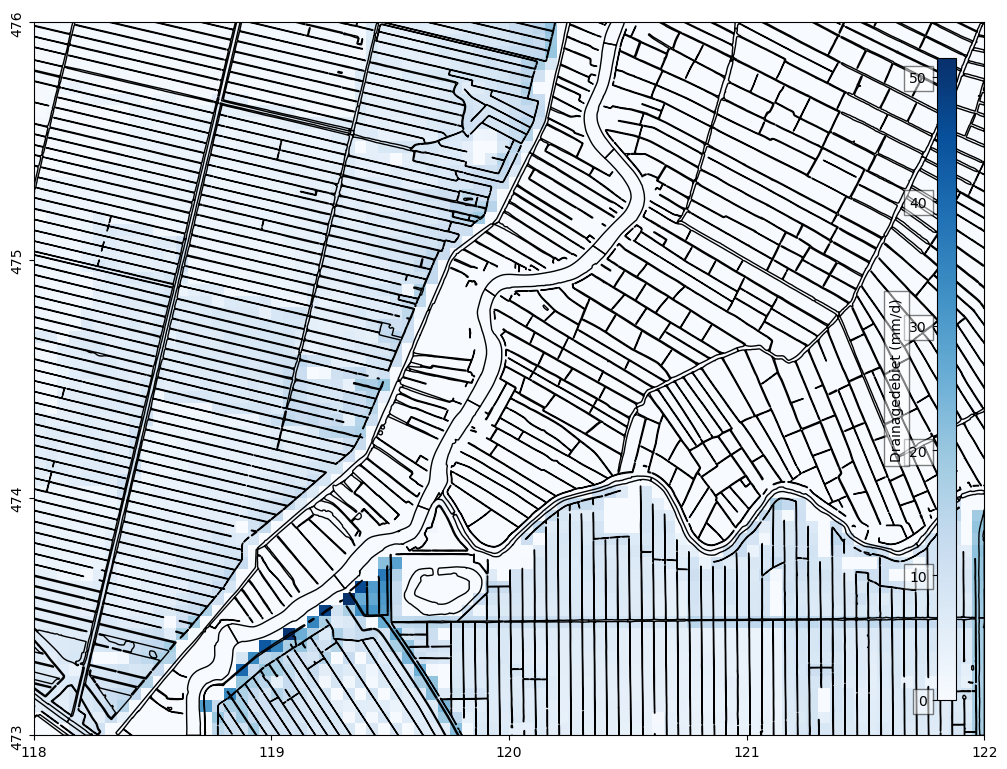

In [23]:
f, ax = nlmod.plot.get_map(extent)
da = -q_drn0.sum('layer').mean('time') / ds['area'] * 1000
pc = nlmod.plot.data_array(da, ds=ds, cmap='Blues')
cbar = nlmod.plot.colorbar_inside(pc, label='Drainagedebiet (mm/d)')
bgt.plot(ax=ax, edgecolor="k", facecolor="none");

## Reken het model nogmaals door met een hoger peil van de Amstel
We willen nu weten wat de invloed is van een hoger peil van de Amstel. Daarom zetten we het peil ('stage') van de Amstel 1 meter hoger, van -0.4 naar 0.6 m NAP, en rekenen het model opnieuw door.

In [24]:
# remove the current RIV-package
gwf.remove_package('RIV')
# set the stage of the Amstel
amstel["stage"] = 0.6
# generate a new riv package
spd = nlmod.gwf.surface_water.build_spd(amstel, "RIV", ds)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data={0: spd})
# run the model again
nlmod.sim.write_and_run(sim, ds)

Building stress period data RIV: 100%|█████████████████████████████████████████████| 231/231 [00:00<00:00, 4353.73it/s]

INFO:nlmod.sim.sim:write model dataset to cache
INFO:nlmod.sim.sim:write modflow files to model workspace


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model Amstel...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package sto...
    writing package rch...
    writing package ts_0...
    writing package ts_1...
    writing package drn_0...
    writing package obs_0...
    writing package ts_2...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 231 based on size of stress_period_data
INFO:nlmod.sim.sim:run model
FloPy is using the following executable to run the model: ..\..\..\nlmod\nlmod\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic

We lezen de uitvoer van model opnieuw in, naar variabelen met namen die eindigen op "1".

In [25]:
head1 = nlmod.gwf.output.get_heads_da(ds)
gws1 = nlmod.gwf.output.get_gwl_from_wet_cells(head1)
q_drn1 = nlmod.gwf.output.get_budget_da('DRN', ds=ds)

## Geef het verschil in grondwaterstand tussen de twee modelsimulaties weer

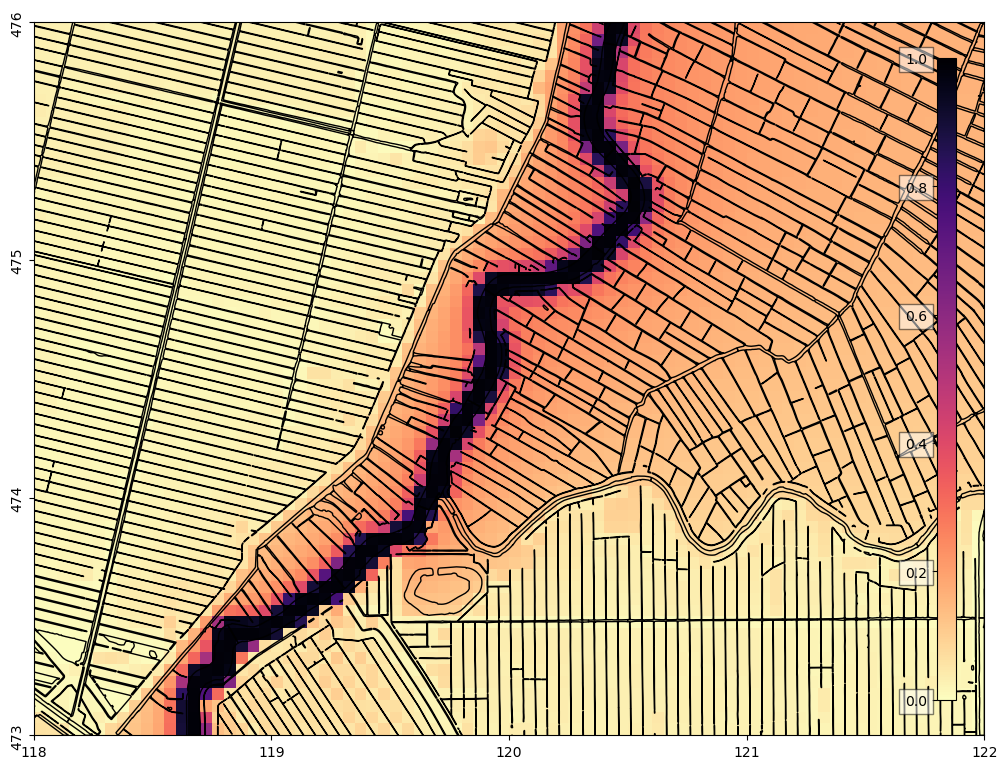

In [26]:
f, ax = nlmod.plot.get_map(extent)
dgws = gws1 - gws0
pc = nlmod.plot.data_array(dgws.mean("time"), ds=ds, vmin=0, vmax=1.0, cmap='magma_r')
cbar = nlmod.plot.colorbar_inside(pc)
bgt.plot(ax=ax, edgecolor="k", facecolor="none");

Het effect in de polders is dus minimaal. Wellicht neemt het drainagedebiet in de buurt van de Amstel wel toe?

Oefening 6: geef de toename van het drainagedebiet weer in mm/d.

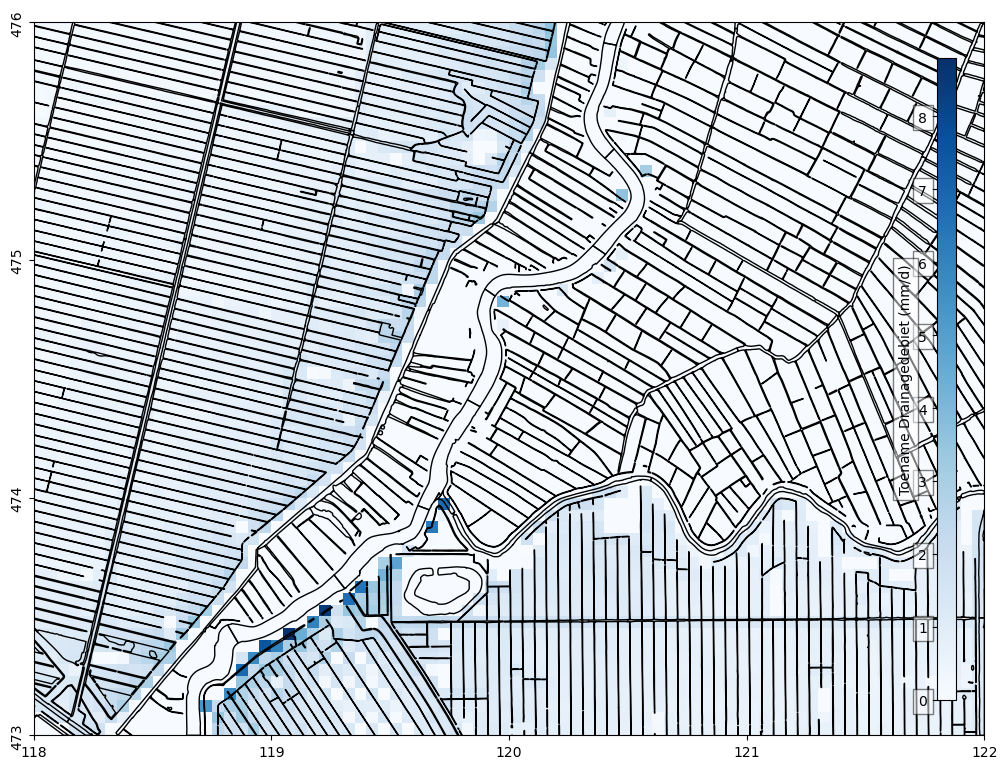

In [27]:
da = (-q_drn1.sum('layer').mean('time') / ds['area'] * 1000) - (-q_drn0.sum('layer').mean('time') / ds['area'] * 1000)
f, ax = nlmod.plot.get_map(extent)
pc = nlmod.plot.data_array(da, ds=ds, cmap='Blues')
cbar = nlmod.plot.colorbar_inside(pc, label='Toename Drainagedebiet (mm/d)')
bgt.plot(ax=ax, edgecolor="k", facecolor="none");

## Extra oefeningen
Snel klaar? Niet getreurd, met onderstaande oefeningen kan je de rest van de middag vullen.

Oefening 7: Voeg gridverfijing toe rond de rivier de Amstel, door de celgrootte hier te halveren. Voeg de functie `nlmod.grid.refine()` toe na `nlmod.to_model_ds()`. Zie het notebook https://nlmod.readthedocs.io/en/stable/examples/09_schoonhoven.html voor een voorbeeld van de argumenten voor deze functie.

Oefening 8: de bovenzijde van het model is de Holocece deklaag (HLc), waarvoor REGIS geen doorlatendheid geeft. Daarom wordt kh op een standaardwaarde van 1.0 m/d en kv op 0.1 m/d gezet (zie de log-berichten na `nlmod.to_model_ds()`). We kunnen GeoTOP gebruiken om een betere schatting te krijgen voor deze doorlatendheden. Verander een argument in `nlmod.read.regis.get_combined_layer_models()` en herbereken het effect van een toename van het peil van Amstel met 1 meter. Omdat de GeoTOP-data meer variatie heeft, met hoge en lage doorlatendheden dichtbij elkaar, heeft het model moeite om te convergeren. Verander het `complexity` argument in `nlmod.sim.ims()` naar `"complex"`, zodat het model wel weer convergeert.